Adapted by Carlos Toxtli https://www.carlostoxtli.com/#colab-datag-3

Source: https://github.com/stratospark/keras-multiprocess-image-data-generator

In [ ]:
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 9.1MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [ ]:
!git clone https://github.com/stratospark/keras-multiprocess-image-data-generator.git
%cd keras-multiprocess-image-data-generator

Cloning into 'keras-multiprocess-image-data-generator'...
remote: Enumerating objects: 84, done.
remote: Total 84 (delta 0), reused 0 (delta 0), pack-reused 84
Unpacking objects: 100% (84/84), done.
/content/keras-multiprocess-image-data-generator


# Accelerating Deep Learning with Multiprocess Image Augmentation in Keras

![Benchmark Results](https://github.com/stratospark/keras-multiprocess-image-data-generator/blob/master/results.png?raw=1)

**Code available @ https://github.com/stratospark/keras-multiprocess-image-data-generator**

* [Introduction](#Introduction)
* [Benchmark: CIFAR10 - In Memory Performance, Image Generation Only](#Benchmark:-CIFAR10---In-Memory-Performance,-Image-Generation-Only)
* [Benchmark: CIFAR10 - In Memory Performance, Image Generation with GPU Training](#Benchmark:-CIFAR10---In-Memory-Performance,-Image-Generation-with-GPU-Training)
* [Benchmark: Dogs vs. Cats - On Disk Performance, Image Generation witih GPU Training](#Benchmark:-Dogs-vs.-Cats---On-Disk-Performance,-Image-Generation-witih-GPU-Training)

## Introduction

**TLDR: By adding multiprocessing support to Keras ImageDataGenerator, benchmarking on a 6-core i7-6850K and 12GB TITAN X Pascal: 3.5x speedup of training with image augmentation on in memory datasets, 3.9x speedup of training with image augmentation on datasets streamed from disk.**

When exploring Deep Learning models, it isn't only beneficial to have good performance for the final training run. Accelerating training speed means more network models can be tried and more hyperparameter settings can be explored in the same amount of time. **The more that we can experiment, the better our results can become.**

In my experience with [training a moderately sized network](http://blog.stratospark.com/deep-learning-applied-food-classification-deep-learning-keras.html) on my home desktop, I found one bottleneck to be creating additional images to augment my dataset. Keras provides an [ImageDataGenerator](https://keras.io/preprocessing/image/) class that can take images, in memory or on disk, and create many different variations based on a set of parameters: rotations, flips, zooms, altering colors, etc. For reference, here is a [great tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) on improving network accuracy with image augmentation.

![cat images augmented](https://blog.keras.io/img/imgclf/cat_data_augmentation.png)

While training my initial models, I was waiting upwards of an entire day to see enough results to decide what to change. I saw that I was taking nowhere near full advantage of my CPU or GPU. As a result, I decided to add some Python multiprocessing support to a fork of ImageDataGenerator. I was able to drastically cut my training time and was finally able to steer my experiments in the right direction!

For reference, I am using:
* Intel Core i7-6850K
* NVIDIA TITAN X Pascal 12GB
* 96GB RAM
* 64-bit Ubuntu 16.04
* Python 2.7.13 :: Continuum Analytics, Inc.
* Keras 1.2.1
* Tensorflow 0.12.1

You can use the multiprocessing-enabled ImageDataGenerator that is included with this repo as a drop-in replacement for the version that currently ships with Keras. If it makes sense, the code may get incorporated into the main branch at some point.

In [ ]:
import numpy as np
import pandas as pd
import keras as K
import matplotlib.pyplot as plt
import multiprocessing
import time
import collections
import sys
import signal

%matplotlib inline

Using TensorFlow backend.


In [ ]:
# The original class can be imported like this:
# from keras.preprocessing.image import ImageDataGenerator

# We access the modified version through T.ImageDataGenerator
import tools.image as T

# Useful for checking the output of the generators after code change
try:
    from importlib import reload
    reload(T)
except:
    reload(T)

These are helper methods used throughout the notebook.

In [ ]:
def preprocess_img(img):
    img = img.astype(np.float32) / 255.0
    img -= 0.5
    return img * 2

In [ ]:
def plot_images(img_gen, title):
    fig, ax = plt.subplots(6, 6, figsize=(10, 10))
    plt.suptitle(title, size=32)
    plt.setp(ax, xticks=[], yticks=[])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    for (imgs, labels) in img_gen:
        for i in range(6):
            for j in range(6):
                if i*6 + j < 32:
                    ax[i][j].imshow(imgs[i*6 + j])
        break    

## Benchmark: CIFAR10 - In Memory Performance, Image Generation Only

[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) is a toy dataset that includes 50,000 training images and 10,000 test images of shape 32x32x3.

It includes the following 10 classes: **airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck**

In [ ]:
from keras.datasets.cifar10 import load_data
from keras.utils.np_utils import to_categorical

(X_train, y_train), (X_test, y_test) = load_data()

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

170500096/170498071 [==============================] - 6s 0us/step


Here is an example of how to set up a `multiprocessing.Pool` and add it as an argument to the ImageDataGenerator constructor. This is the only change to the class' public interface. If you leave out the `pool` parameter or set it to `None`, the generator will operate in its original single process mode.

4 process, duration: 0.09390616416931152


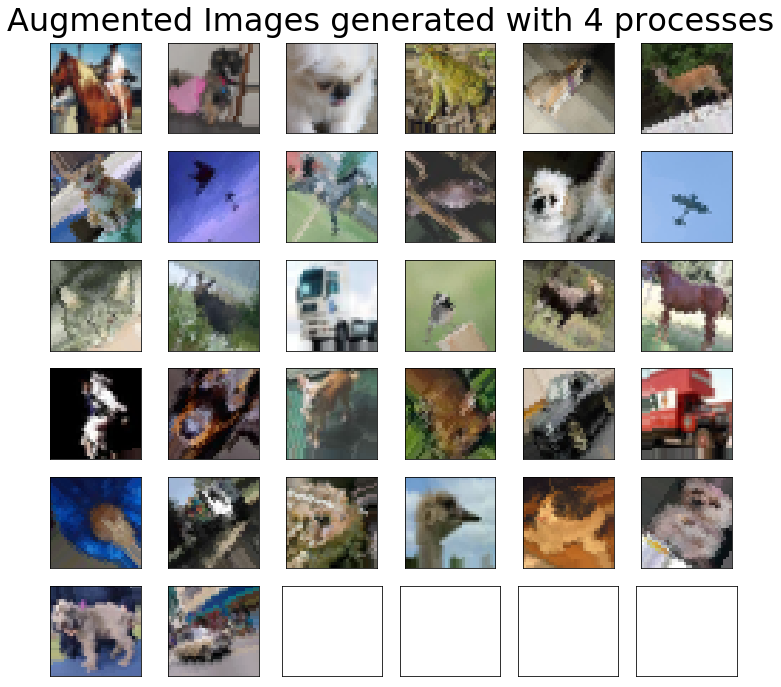

In [ ]:
try:
    pool.terminate()
except:
    pass
n_process = 4
    
pool = multiprocessing.Pool(processes=n_process)
start = time.time()
gen = T.ImageDataGenerator(
     featurewise_center=False,
     samplewise_center=False,
     featurewise_std_normalization=False,
     samplewise_std_normalization=False,
     zca_whitening=False,
     rotation_range=45,
     width_shift_range=.1,
     height_shift_range=.1,
     shear_range=0.,
     zoom_range=0,
     channel_shift_range=0,
     fill_mode='nearest',
     cval=0.,
     horizontal_flip=True,
     vertical_flip=False,
     rescale=1/255.,
     #preprocessing_function=preprocess_img, # disable for nicer visualization
     dim_ordering='default',
     pool=pool # <-------------- Only change needed!
)

gen.fit(X_train)
X_train_aug = gen.flow(X_train, y_train_cat, seed=0)

print('{} process, duration: {}'.format(4, time.time() - start))
plot_images(X_train_aug, 'Augmented Images generated with {} processes'.format(n_process))

pool.terminate()

Now that we have verified that the images are being properly generated with multiple processes, we want to benchmark how the number of processes affects performance. Idealy, we would like to see speedups scale linearly with the number of processes added. However, as explained by [Amdahl's Law](https://en.wikipedia.org/wiki/Amdahl%27s_law), there are diminishing returns due to additional overhead.

The following benchmark will first test image augmentation without multiprocessing, then do a test for an increasing number of processes, up to a max of the number of logical CPUs your system has. It does multiple rounds of these tests so that we may average the results.

In [ ]:
durs = collections.defaultdict(list)
num_cores = 2
try:
    num_cores = multiprocessing.cpu_count()
except:
    pass

for j in range(10):
    print('Round', j)
    
    for num_p in range(0, num_cores + 1):
        pool = None
        if num_p > 0:
            pool = multiprocessing.Pool(processes=num_p)
            
        start = time.time()
        gen = T.ImageDataGenerator(
             featurewise_center=False,
             samplewise_center=False,
             featurewise_std_normalization=False,
             samplewise_std_normalization=False,
             zca_whitening=False,
             rotation_range=45,
             width_shift_range=.1,
             height_shift_range=.1,
             shear_range=0.,
             zoom_range=0,
             channel_shift_range=0,
             fill_mode='nearest',
             cval=0.,
             horizontal_flip=True,
             vertical_flip=False,
             rescale=None,
             preprocessing_function=preprocess_img,
             dim_ordering='default',
             pool=pool
        )

        gen.fit(X_train)
        X_train_aug = gen.flow(X_train, y_train_cat, seed=0)

        for i, (imgs, labels) in enumerate(X_train_aug):
            if i == 1000:
                break

        dur = time.time() - start
        #print(num_p, dur)
        sys.stdout.write('{}: {} ... '.format(num_p, dur))
        sys.stdout.flush()
        
        durs[num_p].append(dur)

        if pool:
            pool.terminate()

Round 0
0: 9.200002670288086 ... 1: 12.75890827178955 ... 2: 12.19498348236084 ... Round 1
0: 9.170865535736084 ... 1: 12.747222661972046 ... 2: 12.158259868621826 ... Round 2
0: 9.025481462478638 ... 1: 12.698202133178711 ... 2: 12.108450412750244 ... Round 3
0: 9.046288251876831 ... 1: 12.952636241912842 ... 2: 12.117230892181396 ... Round 4
0: 9.027145862579346 ... 1: 12.789586067199707 ... 2: 12.199957847595215 ... Round 5
0: 8.976659297943115 ... 1: 12.606961250305176 ... 2: 12.1865234375 ... Round 6
0: 9.173736095428467 ... 1: 12.688228607177734 ... 2: 12.19714641571045 ... Round 7
0: 9.113315105438232 ... 1: 13.05054235458374 ... 2: 12.32142949104309 ... Round 8
0: 9.16667628288269 ... 1: 12.784313440322876 ... 2: 12.185868263244629 ... Round 9
0: 9.046824216842651 ... 1: 13.706783533096313 ... 2: 12.354405641555786 ... 

In [ ]:
df = pd.DataFrame(durs)
df

,0,1,2
0,9.200003,12.758908,12.194983
1,9.170866,12.747223,12.158260
2,9.025481,12.698202,12.108450
3,9.046288,12.952636,12.117231
4,9.027146,12.789586,12.199958
5,8.976659,12.606961,12.186523
6,9.173736,12.688229,12.197146
7,9.113315,13.050542,12.321429
8,9.166676,12.784313,12.185868
9,9.046824,13.706784,12.354406


Text(0.5, 1.0, 'Image Augmentation time vs. # Processes')

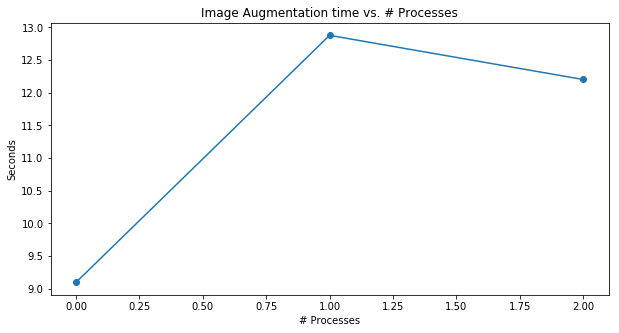

In [ ]:
df_mean = pd.DataFrame(df.mean(axis=0))
plt.figure(figsize=(10,5))
plt.plot(df_mean, marker='o')
plt.xlabel('# Processes')
plt.ylabel('Seconds')
plt.title('Image Augmentation time vs. # Processes')

Text(0.5, 1.0, 'Image Augmentation speedup vs. # Processes')

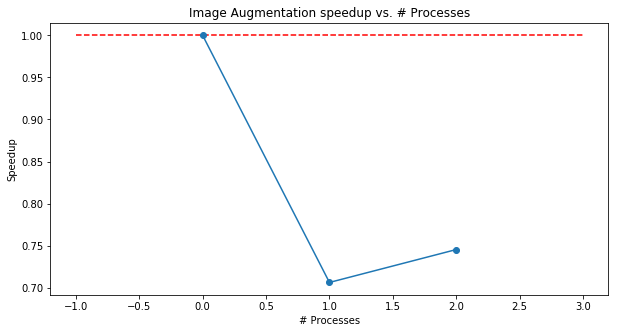

In [ ]:
speedups = 1 / (df_mean / df_mean[0][0])
plt.figure(figsize=(10,5))
plt.plot(speedups, marker='o')
plt.xlabel('# Processes')
plt.ylabel('Speedup')
plt.hlines(1, -1, df_mean.shape[0], colors='red', linestyles='dashed')
plt.title('Image Augmentation speedup vs. # Processes')

In [ ]:
best_ix = np.argmax(speedups.values)
print('Best speedup: {0:.2f}x with {1} processes.'.format(speedups.values[best_ix][0], best_ix))

Best speedup: 1.00x with 0 processes.


As we can see, we are able to cut image generation time in half. However, does the speedup remain when we are also sending the images to the GPU for network trianing?

## Benchmark: CIFAR10 - In Memory Performance, Image Generation with GPU Training

In [ ]:
import tools.sysmonitor as SM
reload(SM)

<module 'tools.sysmonitor' from '/content/keras-multiprocess-image-data-generator/tools/sysmonitor.py'>

Let us take a model from one of the [Keras examples](https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py):

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, 3, 3, border_mode='same',
                        input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  from ipykernel import kernelapp as app


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

When we are running lengthier training sessions, we may want to interrupt training to try a different approach: tweak hyperparameters, choose a different optimizer, adjust the network architecture, etc. In order to handle this gracefully with multiprocessing, we need to tell the child processes to ignore the interrupt signals. The parent process will catch the KeyboardInterrupt exception allow us to continue working interactively in the Notebook. Without this infrastructure, the processes will remain in limbo as detailed [here](http://noswap.com/blog/python-multiprocessing-keyboardinterrupt).

In [ ]:
pool = None

def init_worker():
    signal.signal(signal.SIGINT, signal.SIG_IGN)

In [ ]:
def setup_generator(processes=None, batch_size=32):
    global pool
    try:
        pool.terminate()
    except:
        pass

    if processes: 
        pool = multiprocessing.Pool(processes=processes, initializer=init_worker)
    else:
        pool = None

    gen = T.ImageDataGenerator(
         featurewise_center=False,
         samplewise_center=False,
         featurewise_std_normalization=False,
         samplewise_std_normalization=False,
         zca_whitening=False,
         rotation_range=45,
         width_shift_range=.1,
         height_shift_range=.1,
         shear_range=0.,
         zoom_range=[.8, 1],
         channel_shift_range=20,
         fill_mode='nearest',
         cval=0.,
         horizontal_flip=True,
         vertical_flip=False,
         rescale=None,
         preprocessing_function=preprocess_img,
         dim_ordering='default',
         pool=pool
    )
    test_gen = T.ImageDataGenerator(
        preprocessing_function=preprocess_img,
        pool=pool
    )
    
    gen.fit(X_train)
    test_gen.fit(X_train)
    
    X_train_aug = gen.flow(X_train, y_train_cat, seed=0, batch_size=batch_size)
    X_test_aug = test_gen.flow(X_test, y_test_cat, seed=0, batch_size=batch_size)
    
    return X_train_aug, X_test_aug

In [ ]:
def run_benchmark(processes=None, batch_size=32, vert=True, plot=True):
    X_train_aug, X_test_aug = setup_generator(processes=processes, batch_size=batch_size)
    sys_mon = SM.SysMonitor()
    sys_mon.start()
    
    try:
        model.fit_generator(X_train_aug, samples_per_epoch=50000, nb_epoch=5, 
                        validation_data=X_test_aug, nb_val_samples=10000)
    except KeyboardInterrupt:
        print '\n\nTraining Interrupted\n'
        return None

    sys_mon.stop()
    
    title = None
    if not processes:
        title = '{0:.2f} seconds of computation, no multiprocessing, batch size = {1}'.format(sys_mon.duration, batch_size)
    else:
        title = '{0:.2f} seconds of computation, using {1} processes, batch size = {2}'.format(sys_mon.duration, processes, batch_size)
    
    if plot:
        sys_mon.plot(title, vert)
    
    if not processes:
        processes = 0
        
    return {
        'processes': processes,
        'batch_size': batch_size,
        'duration': sys_mon.duration,
        'title': title
    }

SyntaxError: ignored

In [ ]:
run_benchmark(processes=None, batch_size=32)

In [ ]:
run_benchmark(processes=7, batch_size=32)

Now let's try a variety of different test scenarios:

In [ ]:
runs = []

In [ ]:
runs.append(run_benchmark(processes=None, batch_size=32))

In [ ]:
runs.append(run_benchmark(processes=7, batch_size=32))

In [ ]:
runs[0]['duration'] / runs[1]['duration']

As we can see, we can get a **1.8x speedup by using 7 processes**. The GPU and CPU utilization is markedly higher and more consistent.

Let's see if batch size affects the outcome:

In [ ]:
runs.append(run_benchmark(processes=None, batch_size=256))

In [ ]:
runs.append(run_benchmark(processes=7, batch_size=256))

In [ ]:
runs[2]['duration'] / runs[3]['duration']

With a batch size of 256, we get an **even larger speedup of 3.3x**

In [ ]:
runs.append(run_benchmark(processes=None, batch_size=1024))

In [ ]:
runs.append(run_benchmark(processes=7, batch_size=1024))

In [ ]:
runs[4]['duration'] / runs[5]['duration']

With a batch size of 1024, we get **a speedup of 3.48%**. We also notice an interesting phenomenon. Without multiprocessing, the GPU is interittently going to 0 utilization. However, with 7 processes, we can see consistent >60% GPU utilization with a long initial period of >80%. Notice that with this batch size, we are able to get to lower losses a lot quicker than with lower batch sizes. This pattern will not necessarily continue with additional epochs, but it may be promising in some cases.

In [ ]:
runs.append(run_benchmark(processes=None, batch_size=4096))

In [ ]:
runs.append(run_benchmark(processes=7, batch_size=4096))

In [ ]:
runs[6]['duration'] / runs[7]['duration']

A larger batch size of 4096 may or may not be a good choice in all cases, but when it comes to measuring system performance, we can see that the GPU usage is not consistent in the single process case. On the other hand, we are getting between 80-100% GPU utilization with 7 processes.

Let's do a final experiment with this dataset to see how Image Augmentation + GPU Training time scales with process count:

In [ ]:
processes_counts = [None]
processes_counts.extend(range(1, 13))

results = []

for pc in processes_counts:
    print('process count', pc)
    results.append(run_benchmark(processes=pc, batch_size=4096, plot=False))

In [ ]:
durs_4096 = pd.DataFrame([x['duration'] for x in results])
plt.figure(figsize=(10,5))
plt.plot(durs_4096, marker='o')
plt.xlabel('# Processes')
plt.ylabel('Seconds')
plt.title('Image Augmentation + GPU Training time vs. # Processes')

In [ ]:
speedups_4096 = 1 / (durs_4096 / durs_4096.ix[0])

plt.figure(figsize=(10,5))
plt.plot(speedups_4096, marker='o')
plt.xlabel('# Processes')
plt.ylabel('Speedup')
plt.hlines(1, -1, speedups_4096.shape[0], colors='red', linestyles='dashed')
plt.title('Image Augmentation + GPU Training speedup vs. # Processes')

In [ ]:
best_ix = np.argmax(speedups_4096.values)
print('Best speedup: {0:.2f}x with {1} processes.'.format(speedups_4096.values[best_ix][0], best_ix))

## Benchmark: Dogs vs. Cats - On Disk Performance, Image Generation witih GPU Training

Using the images in the [dogs vs. cats dataset](https://www.kaggle.com/c/dogs-vs-cats/data) provided by Kaggle, we can test the performance of image augmentation on images loaded from disk on the fly.

To follow along, unzip the downloaded training zip file, then create a `data/train/cat`, `/data/train/dog`, `data/validation/cat`, and `data/validation/dog` folders. 

Then move the images that have indicies starting with 8 into the appropriate validation folders.

`
mv cat.8* data/validation/cat/
mv dog.8* data/validation/dog/
`

In [ ]:
import os

paths = sorted(os.listdir('./data/train/cat'))

fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ix = i*5 + j
        img = plt.imread('./data/train/cat/' + paths[ix])
        ax[i][j].imshow(img)


In [ ]:
paths = sorted(os.listdir('./data/train/dog'))

fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ix = i*5 + j
        img = plt.imread('./data/train/dog/' + paths[ix])
        ax[i][j].imshow(img)


In [ ]:
gen = T.ImageDataGenerator(
     featurewise_center=False,
     samplewise_center=False,
     featurewise_std_normalization=False,
     samplewise_std_normalization=False,
     zca_whitening=False,
     rotation_range=45,
     width_shift_range=.1,
     height_shift_range=.1,
     shear_range=0.,
     zoom_range=[.8, 1],
     channel_shift_range=0,
     fill_mode='nearest',
     cval=0.,
     horizontal_flip=True,
     vertical_flip=False,
     rescale=1/255.,
#      preprocessing_function=preprocess_img,
     #dim_ordering='default',
#      pool=None
)
test_gen = T.ImageDataGenerator(
    preprocessing_function=preprocess_img,
#     pool=None
)


train_generator = gen.flow_from_directory(
    'data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

test_generator = gen.flow_from_directory(
    'data/validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

fig, ax = plt.subplots(6, 6, figsize=(15, 15))
for (imgs, labels) in train_generator:
    for i in range(6):
        for j in range(6):
            if i*6 + j < 32:
                ax[i][j].imshow(imgs[i*6 + j])
    break


In [ ]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(299, 299, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [ ]:
def setup_cat_dog_generator(processes=None, batch_size=32):
    global pool
    try:
        pool.terminate()
    except:
        pass

    if processes: 
        pool = multiprocessing.Pool(processes=processes, initializer=init_worker)
    else:
        pool = None

    gen = T.ImageDataGenerator(
         featurewise_center=False,
         samplewise_center=False,
         featurewise_std_normalization=False,
         samplewise_std_normalization=False,
         zca_whitening=False,
         rotation_range=45,
         width_shift_range=.1,
         height_shift_range=.1,
         shear_range=0.,
         zoom_range=[.8, 1],
         channel_shift_range=20,
         fill_mode='nearest',
         cval=0.,
         horizontal_flip=True,
         vertical_flip=False,
         rescale=None,
         preprocessing_function=preprocess_img,
         dim_ordering='default',
         pool=pool
    )
    test_gen = T.ImageDataGenerator(
        preprocessing_function=preprocess_img,
        pool=pool
    )
    
    gen.fit(X_train)
    test_gen.fit(X_train)
    
    X_train_aug = gen.flow_from_directory(
        'data/train',
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='binary')

    X_test_aug = gen.flow_from_directory(
        'data/validation',
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='binary')
    
    return X_train_aug, X_test_aug

In [ ]:
def run_cat_dog_benchmark(processes=None, batch_size=32, vert=True, plot=True):
    
    X_train_aug, X_test_aug = setup_cat_dog_generator(processes=processes, batch_size=batch_size)
    sys_mon = SM.SysMonitor()
    sys_mon.start()
    
    try:        
        model.fit_generator(
                X_train_aug,
                samples_per_epoch=22778,
                nb_epoch=2,
                validation_data=X_test_aug,
                nb_val_samples=2222)
    except KeyboardInterrupt:
        print '\n\nTraining Interrupted\n'
        return None

    sys_mon.stop()
    
    title = None
    if not processes:
        title = '{0:.2f} seconds of computation, no multiprocessing, batch size = {1}'.format(sys_mon.duration, batch_size)
    else:
        title = '{0:.2f} seconds of computation, using {1} processes, batch size = {2}'.format(sys_mon.duration, processes, batch_size)
    
    if plot:
        sys_mon.plot(title, vert)
    
    if not processes:
        processes = 0
        
    return {
        'processes': processes,
        'batch_size': batch_size,
        'duration': sys_mon.duration,
        'title': title
    }

In the following benchmark runs, you can see how inconsistent the GPU is being used without multiprocessing. Even with multiprocessing, the CPU is struggling to get enough data to the GPU to keep the GPU utilization stable. However, it's averaging out to be much higher than before.

Before running each benchmark, I run: 

`sync; echo 3 > /proc/sys/vm/drop_caches` 

in the shell. This clears any diles that may be cached in memory that could be skewing the benchmarking results.

In [ ]:
runs = []

In [ ]:
runs.append(run_cat_dog_benchmark(processes=None, batch_size=64))

In [ ]:
runs.append(run_cat_dog_benchmark(processes=7, batch_size=64))

In [ ]:
runs.append(run_cat_dog_benchmark(processes=11, batch_size=64))

In [ ]:
runs[0]['duration'] / runs[2]['duration']

As we can see, we can get an even bigger performance gain when flowing from disk. Using 11 processes, we are getting 3.94x performance over single threaded. This will really help a lot when working with larger than memory datasets.